# Image Super Resolution

## Importing all necessary libraries

In [2]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
import h5py

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
%matplotlib inline

## Image Quality Measures (PSNR,MSE and SSIM)

#### Function for peak signal to noise ratio (PSNR)

In [4]:
def psnr(target, ref):

    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

#### Function for Mean Squared Error (MSE)

In [5]:
def mse(target, ref):

    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

#### Function that combines all metrices

In [6]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

## Preparing Images

In [7]:
def prepare_images(path, factor):

    for file in os.listdir(path):

        img = cv2.imread(path + '/' + file)

        h, w, c = img.shape
        new_height = h/factor
        new_width = w/factor

        img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)

        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [8]:
prepare_images('source/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


## Testing Low Resolution Images

In [9]:
for file in os.listdir('images/'):

    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))

    scores = compare_images(target, ref)

    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9356987872724932

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.948005676

## Building the SRCNN Model

In [9]:
def model():

    SRCNN = Sequential()

    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    adam = Adam(lr=0.0003)

    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

## Deploying SRCNN

In [10]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [11]:
def predict(image_path):

    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))

    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
 
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    pre = srcnn.predict(Y, batch_size=1)

    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    return ref, degraded, output, scores

## Result

C:\Users\Deepak Kumar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Degraded Image: 
PSNR: 31.35857283101428
MSE: 142.6738341696767
SSIM: 0.8459403992986435

Reconstructed Image: 
PSNR: 33.10844723748565
MSE: 95.35794687805549
SSIM: 0.8682031316784745



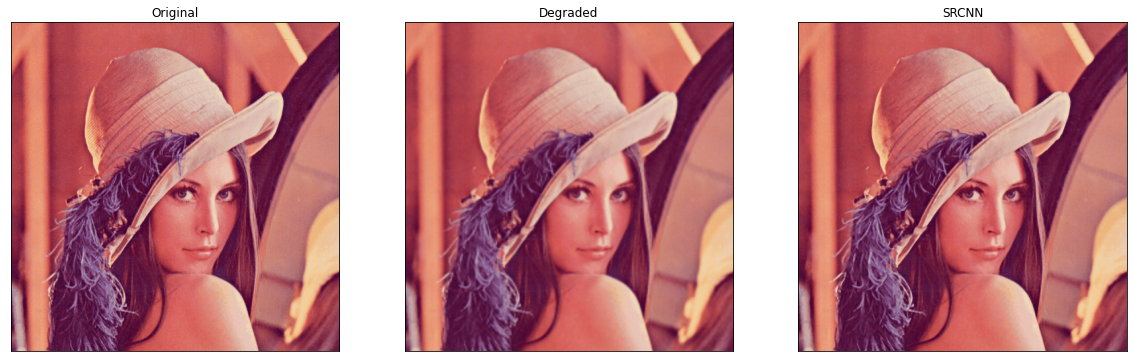

In [12]:
ref, degraded, output, scores = predict('images/lenna.bmp')

print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
for file in os.listdir('images'):

    ref, degraded, output, scores = predict('images/{}'.format(file))

    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [16]:
def predct(image_path):

    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)

    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
 
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    pre = srcnn.predict(Y, batch_size=1)

    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    degraded = shave(degraded.astype(np.uint8), 6)

    scores = []

    return degraded, output

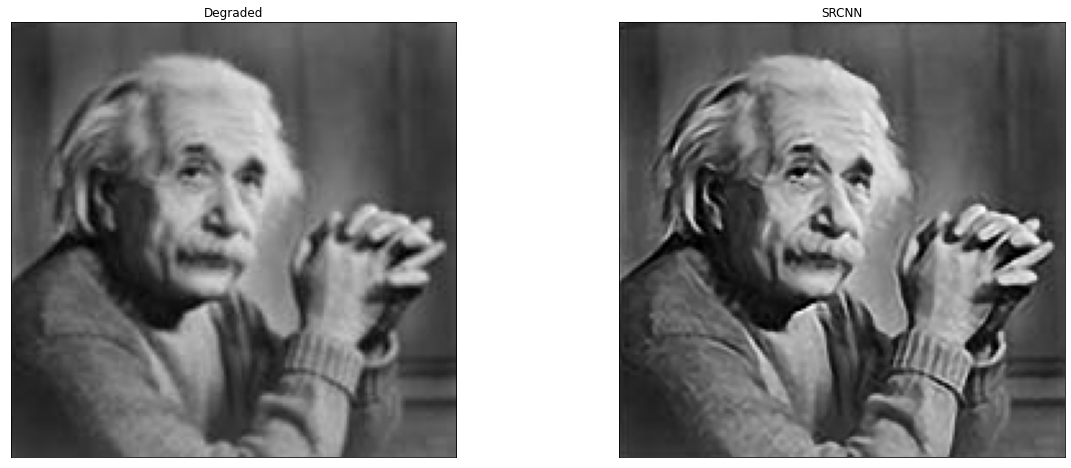

In [18]:
degraded, output = predct('aaa.jpg')

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('SRCNN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])